# M2608.001300 Machine Learning <br> Assignment #7 : Convolutional Neural Netowrks and Knowledge Distillation

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Heonseok Ha, June 2018

There are **3 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

1. [Building a compuatational graph of CNN model](#1) ( 30 points ) <br>
You will stack the various types of layers.

2. [Building and training the teacher model](#2) ( 30 points ) <br>
You will implment the loss, optimizer and training/inference function.<br>
The goal here isn't to get good performance. <br>

3. [Building and training the student model](#3) ( 40 points ) <br>
You will try to implement knowledge distillation and see the effect. <br>
The goal is to achieve better performance when using knowledge distillation. <br>

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Some helpful tutorials and references for assignment #7:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/tutorials/layers)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] **Distilling the Knowledge in a Neural Network** [[link]](https://arxiv.org/pdf/1503.02531.pdf) <br>
**It is highly recommended that you read the section 1~3 of this paper to understand the concept of knowledge distillation.** <br>

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **student_id** as input argument. <br>
This will produce a zipped file called *[student_id].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; student_id)


## Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *Utils* directory. <br>

In [114]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from Utils.data_utils import load_CIFAR10, plot_images
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Data has already been downloaded and unpacked.
Train data shape (40000, 32, 32, 3)
Train labels shape (40000,)
Validation data shape (10000, 32, 32, 3)
Validataion labels shape (10000,)
Test data shape (10000, 32, 32, 3)
Test labels shape (10000,)


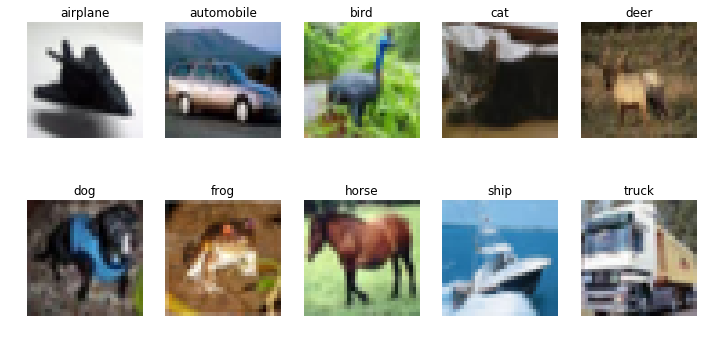

In [115]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, Class_names = load_CIFAR10()
print('Train data shape ' + str(X_train.shape))
print('Train labels shape ' + str(Y_train.shape))
print('Validation data shape ' + str(X_val.shape))
print('Validataion labels shape ' + str(Y_val.shape))
print('Test data shape ' + str(X_test.shape))
print('Test labels shape ' + str(Y_test.shape))
plot_images(X_train, Y_train, Class_names, Each_Category=True)

## <a name="1"></a> 1. Building computational graphs of CNN model ( 30 points )
In this section, you will stack the various types of layers to implment base_cnn_model.
Base_cnn_model is the parent class of the teacher_cnn_model and student_cnn_model.

#### Build_model:
* L1 layer : <br>
5x5 Convolutional layer with 6 filters, strides of 1, zero padding, and ReLU activation <br>
3x3 Max pooling layer with strides of 3 <br><br>
* L2 layer : <br>
5x5 Convolutional layer with 16 fiilters, strides of 1, zero padding, and ReLU activation <br>
3x3 Max pooling layer with strides of 3 <br><br>
* L3 layer : <br>
Fully connected layer with 128 output units and ReLU activation <br><br>
* Output layer (logit): <br>
Fully connected layer with 10 output units and linear activation <br>

In [116]:
class base_cnn_model(object):
    def __init__(self, model_name='simple_cnn', ckpt_dir='./checkpoint', input_width=32, input_height=32, num_input_filter=3, n_labels=10):
        self.model_name = model_name
        self.ckpt_dir = ckpt_dir

        self.width = input_width
        self.height = input_height
        self.num_input_filter = num_input_filter
        self.n_labels = n_labels

        if not os.path.exists(self.ckpt_dir):
            os.mkdir(self.ckpt_dir)
    
    def build_model(self):

        # Define input variables 
        self.inputs = tf.placeholder(tf.float32, [None, self.width, self.height, self.num_input_filter])
        self.targets = tf.placeholder(tf.int64, [None])
        self.is_training = tf.placeholder(tf.bool)

        # Define 
        n_L1_filters = 6
        n_L2_filters = 16
        n_L3_filters = 128
        n_outputs = 10
        
        st_conv = [1, 1]
        st_pool = [3, 3]
        
        fil_conv = [5, 5]
        fil_pool = [3, 3]
        
        with tf.variable_scope(self.model_name):
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            
            ###L1 Layer
            
            L1 = tf.layers.conv2d(self.inputs, n_L1_filters, fil_conv, strides=st_conv, padding='same', activation=tf.nn.relu)
            L1 = tf.layers.max_pooling2d(L1, fil_pool, st_pool, padding='same')
            
            
            ###L2 Layer
            
            L2 = tf.layers.conv2d(L1, n_L2_filters, fil_conv, strides=st_conv, padding='same', activation=tf.nn.relu)
            L2 = tf.layers.max_pooling2d(L2, fil_pool, st_pool, padding='same')
            
            #L3 Layer
            L3 = tf.contrib.layers.flatten(L2)
            L3 = tf.layers.dense(L3, n_L3_filters, activation=tf.nn.relu)
            
            self.outputs = tf.layers.dense(L3, n_outputs, activation=None)
           
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
    
    def save(self, sess, global_step):
        ckpt_path = os.path.join(self.ckpt_dir, self.model_name)
        if not os.path.exists(ckpt_path):
            os.mkdir(ckpt_path)
        self.saver.save(sess, os.path.join(ckpt_path, 'cnn'), global_step=global_step)


    def load(self, sess):
        ckpt_path = os.path.join(self.ckpt_dir, self.model_name)
        ckpt = tf.train.get_checkpoint_state(ckpt_path)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(sess, os.path.join(ckpt_path, ckpt_name))

## <a name="2"></a> 2. Building and training the teacher model ( 30 points )

### Building optimizer and implement run_model
The teacher_cnn_model is a just basic CNN model. 

#### build_optimizer:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.01 learning rate

#### run_model: 
* Run session
* Calculate loss or accuracy


In [117]:
class teacher_cnn_model(base_cnn_model):
    def __init__(self, model_name='teacher_cnn', ckpt_dir='./teacher_checkpoint', input_width=32, input_height=32, num_input_filter=3, n_labels=10):
        base_cnn_model.__init__(self, model_name, ckpt_dir, input_width, input_height, num_input_filter, n_labels)
        self.build_model()
        self.build_optimizer()
        self.saver = tf.train.Saver()
           
    def build_optimizer(self):
        ### Define loss function and optimizer
        with tf.variable_scope(self.model_name):
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            cross_ent = tf.nn.softmax_cross_entropy_with_logits(logits=self.outputs, labels=tf.one_hot(self.targets,10))
            self.loss = tf.reduce_mean(cross_ent, name="loss")
            self.optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(self.loss)
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
            ### Variables for evaluation
            self.corr = tf.equal(self.targets, tf.argmax(self.outputs,1))
            self.accuracy = tf.reduce_mean(tf.cast(self.corr, tf.float32)) 

    def run_model(self, sess, X, Y, epochs=1, batch_size=500, is_training=False):
        ### For training the model
        if is_training:           
            for epoch in range(epochs):
                total_loss = 0
                # Iterate over the entire dataset
                for i in range(int(X.shape[0] / batch_size)):
                    ##############################################################################
                    #                          IMPLEMENT YOUR CODE                               #
                    ##############################################################################
                    _, cost_val = sess.run([self.optimizer, self.loss], 
                                       feed_dict={self.inputs: X[i*batch_size:(i+1)*batch_size],
                                                  self.targets: Y[i*batch_size:(i+1)*batch_size],
                                                  self.is_training: is_training})
                    total_loss += cost_val
                    ##############################################################################
                    #                             END OF YOUR CODE                               #
                    ##############################################################################
                if epoch%10 == 9:    
                    print("Epoch: %02d \t Average loss: %.4f" % (epoch+1, total_loss / X.shape[0] * batch_size))
                self.save(sess, epoch)

            print("Training done!")

        ### Evaluate loss and accuracy of the model
        else:
            loss, accuracy = 0.0, 0.0
            for i in range(int(X.shape[0] / batch_size)):
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                l, a = sess.run([self.loss, self.accuracy],
                            feed_dict={self.inputs: X[i*batch_size:(i+1)*batch_size],
                                       self.targets: Y[i*batch_size:(i+1)*batch_size],
                                       self.is_training: is_training})
                loss += l
                accuracy += a
                ##############################################################################
                #                             END OF YOUR CODE                               #
                ##############################################################################
            return (loss / X.shape[0] * batch_size, accuracy / X.shape[0] * batch_size)

### Configuration of TF session and sampling training data
Sampled small trainig data is used for perforamnce comparation and training the student_cnn_model.

In [118]:
### Configuration of session 
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

### Sampling small training data.
rand_idx = np.random.permutation(10000)
X_train_small = X_train[rand_idx,:]
Y_train_small = Y_train[rand_idx]

print('Small train data shape ' + str(X_train_small.shape))
print('Small train labels shape ' + str(Y_train_small.shape))


Small train data shape (10000, 32, 32, 3)
Small train labels shape (10000,)


### Performance comparison 
**Train data** vs **small train data**

In [124]:
### Small training data
tf.reset_default_graph()   
teacher_model = teacher_cnn_model()  

with tf.Session(config=conf) as sess:
    sess.run(tf.global_variables_initializer())
    teacher_model.run_model(sess, X_train_small, Y_train_small, epochs=100, is_training=True)
    print("SMALL TRAIN : (Loss, Accuracy) on Test Dataset (%.4f, %.2f)" % teacher_model.run_model(sess, X_test, Y_test)) 


#### Training data
tf.reset_default_graph()   
teacher_model = teacher_cnn_model()  

with tf.Session(config=conf) as sess:
    sess.run(tf.global_variables_initializer())
    teacher_model.run_model(sess, X_train, Y_train, epochs=100, is_training=True)
    print("TRAIN : (Loss, Accuracy) on Test Dataset (%.4f, %.2f)" % teacher_model.run_model(sess, X_test, Y_test))                                                                                                  

    


Epoch: 10 	 Average loss: 1.9146
Epoch: 20 	 Average loss: 1.7112
Epoch: 30 	 Average loss: 1.5728
Epoch: 40 	 Average loss: 1.4824
Epoch: 50 	 Average loss: 1.4158
Epoch: 60 	 Average loss: 1.3637
Epoch: 70 	 Average loss: 1.3202
Epoch: 80 	 Average loss: 1.2829
Epoch: 90 	 Average loss: 1.2484
Epoch: 100 	 Average loss: 1.2169
Training done!
SMALL TRAIN : (Loss, Accuracy) on Test Dataset (1.3572, 0.52)
Epoch: 10 	 Average loss: 1.5762
Epoch: 20 	 Average loss: 1.4130
Epoch: 30 	 Average loss: 1.3204
Epoch: 40 	 Average loss: 1.2511
Epoch: 50 	 Average loss: 1.1969
Epoch: 60 	 Average loss: 1.1513
Epoch: 70 	 Average loss: 1.1133
Epoch: 80 	 Average loss: 1.0804
Epoch: 90 	 Average loss: 1.0518
Epoch: 100 	 Average loss: 1.0266
Training done!
TRAIN : (Loss, Accuracy) on Test Dataset (1.1343, 0.60)


## <a name="3"></a> 3. Building and training the student model ( 40 points )

#### build_optimizer
* Soft target [3] will be given from the teacher model. 
* Loss function : You can use soft targets to improve the loss function of student model.
* *softmax_with_temperature* will be useful.
* Optimizer : Same as the teacher model

#### run_model
* It is almost identical to the teacher model.
* Soft target must be obtained from the trained teacher model.

In [125]:
class student_cnn_model(base_cnn_model):
    def __init__(self, model_name='student_cnn', ckpt_dir='./student_checkpoint', input_width=32, input_height=32, num_input_filter=3, n_labels=10, soft_portion=0.5,  temp=1):
        base_cnn_model.__init__(self, model_name, ckpt_dir, input_width, input_height, num_input_filter, n_labels)
        
        self.soft_portion = soft_portion
        self.temp = temp
        self.build_model()
        self.build_optimizer()
        self.saver = tf.train.Saver()
        
    def softmax_with_temperature(self, logits, temp=1.0):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        return tf.nn.softmax(logits / temp)
    
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        

    def build_optimizer(self):
        self.soft_target = tf.placeholder(tf.float32, [None, self.n_labels])
        with tf.variable_scope(self.model_name):
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################            
            
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################    
            hard_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
                                       (logits=self.outputs, labels=tf.one_hot(self.targets,10)), name="hard_loss")
            soft_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.outputs, labels=self.softmax_with_temperature(self.soft_target, temp=3.0)), name="soft_loss")
            
            self.loss = 2*((1-self.soft_portion) * hard_loss + self.soft_portion * soft_loss)
            self.optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(self.loss)
            
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
            # Variables for evaluation
            self.corr = tf.equal(self.targets, tf.argmax(self.outputs,1))
            self.accuracy = tf.reduce_mean(tf.cast(self.corr, tf.float32))
            
            
    def run_model(self, sess, X, Y, teacher_model, epochs=1, batch_size=500, is_training=False, verbose=True):
        ### For training the model
        
        
        if is_training:
           
            
            for epoch in range(epochs):
                total_loss = 0
                # Iterate over the entire dataset
                for i in range(int(X.shape[0] / batch_size)):
                    ##############################################################################
                    #                          IMPLEMENT YOUR CODE                               #
                    ##############################################################################

                    # output result from teacher_model 
                    los, outs = sess.run([teacher_model.loss, teacher_model.outputs],
                            feed_dict={teacher_model.inputs: X[i*batch_size:(i+1)*batch_size],
                                       teacher_model.targets: Y[i*batch_size:(i+1)*batch_size],
                                       teacher_model.is_training: is_training})
                    #print(outs.shape)
                    #outs = tf.convert_to_tensor(outs)
                    #print(outs)
                    
                    #soft_outs = self.softmax_with_temperature(outs, self.temp)
                    
                    #print(soft_outs.shape)
                    _, cost_val = sess.run([self.optimizer, self.loss], 
                                       feed_dict={self.inputs: X[i*batch_size:(i+1)*batch_size],
                                                  self.targets: Y[i*batch_size:(i+1)*batch_size],
                                                  self.is_training: is_training,
                                                  self.soft_target: outs})
                    total_loss += cost_val
                    #print(cost_val)
                    #print("!@", ce)
                    ##############################################################################
                    #                             END OF YOUR CODE                               #
                    ##############################################################################
                    
                if verbose and epoch%10 == 9:
                    print("Epoch: %02d \t Average loss: %.4f" % (epoch+1, total_loss / X.shape[0] * batch_size))
                self.save(sess, epoch)

            if verbose :
                print("Training done!")

        ### Evaluate loss and accuracy of the model
        else:
            loss, accuracy = 0.0, 0.0
            for i in range(int(X.shape[0] / batch_size)):
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                outs = sess.run(teacher_model.outputs,
                            feed_dict={teacher_model.inputs: X[i*batch_size:(i+1)*batch_size],
                                       teacher_model.targets: Y[i*batch_size:(i+1)*batch_size],
                                       teacher_model.is_training: is_training})
                                       
                l, a = sess.run([self.loss, self.accuracy],
                            feed_dict={self.inputs: X[i*batch_size:(i+1)*batch_size],
                                       self.targets: Y[i*batch_size:(i+1)*batch_size],
                                       self.is_training: is_training,
                                       self.soft_target: outs})
                loss += l
                accuracy += a
                ##############################################################################
                #                             END OF YOUR CODE                               #
                ##############################################################################
            return (loss / X.shape[0] * batch_size, accuracy / X.shape[0] * batch_size)

### Train the student model using knowledge distillation.
Repeat 10 times to calculate average accuracy.

In [126]:
#This is the result with distillation

acc_list = []
for i in range(10):
    tf.reset_default_graph()   
    # teacher = teacher_cnn_model()

    teacher_model = teacher_cnn_model()
    student_model = student_cnn_model(soft_portion=0.01, temp=3)

    with tf.Session(config=conf) as sess:
        sess.run(tf.global_variables_initializer())
        ### Load the trained student model. 
        teacher_model.load(sess)
        
        ### Note that the teacher model is tansfered to the student model.
        student_model.run_model(sess, X_train_small, Y_train_small, teacher_model, epochs=100, is_training=True)
        loss, acc = student_model.run_model(sess, X_test, Y_test, teacher_model) 
        print("Accuracy: %.4f" % acc)
        acc_list.append(acc)
        
print("Average accuracy: %.4f" % np.average(acc_list))

INFO:tensorflow:Restoring parameters from ./teacher_checkpoint/teacher_cnn/cnn-99
Epoch: 10 	 Average loss: 3.4549
Epoch: 20 	 Average loss: 3.1367
Epoch: 30 	 Average loss: 2.9422
Epoch: 40 	 Average loss: 2.7870
Epoch: 50 	 Average loss: 2.6624
Epoch: 60 	 Average loss: 2.5472
Epoch: 70 	 Average loss: 2.4547
Epoch: 80 	 Average loss: 2.3737
Epoch: 90 	 Average loss: 2.3097
Epoch: 100 	 Average loss: 2.2169
Training done!
Accuracy: 0.5238
INFO:tensorflow:Restoring parameters from ./teacher_checkpoint/teacher_cnn/cnn-99
Epoch: 10 	 Average loss: 3.4806
Epoch: 20 	 Average loss: 3.1142
Epoch: 30 	 Average loss: 2.8899
Epoch: 40 	 Average loss: 2.7249
Epoch: 50 	 Average loss: 2.5877
Epoch: 60 	 Average loss: 2.4772
Epoch: 70 	 Average loss: 2.4013
Epoch: 80 	 Average loss: 2.3099
Epoch: 90 	 Average loss: 2.2209
Epoch: 100 	 Average loss: 2.1661
Training done!
Accuracy: 0.5376
INFO:tensorflow:Restoring parameters from ./teacher_checkpoint/teacher_cnn/cnn-99
Epoch: 10 	 Average loss: 3.

### Describe what you did here
Describe how you have used the teacher model to learn the student model.


At build_optimizer function, two loss functions are defined. 
One is "hard_loss", a cross entropy between the output and the the one-hot encoded target(label) 
and the other is "soft_loss", which is a  cross entropy between the output and the soft target given by a tensorflow placeholder
Then the weighted sum of two loss function(the ratio is given by 1-soft_portion:soft_portion) is used as a final loss function of the student-model.

Finally at run_model function, soft target is computed by feeding our training set to the teacher-model, which is then fed to the soft target placeholder of the student model. Then finally, student model can be trained using the same training set.

As a result, the accuracy of the student-model seemed to be increased by a little scope  comparing to the same model without the soft target(the one trained with the hard target only). However, it is hard to compare the performance of the two model, since the given number of apoches(100 times) is too short to guarantee the convergence of the models and hence making the output result(accuracy) not fully-optimizal. 